In [1]:
import import_ipynb
from ConsistencyIndexes import *
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from IPython.display import clear_output
import torch.optim as optim
from torch.nn.functional import mse_loss
from torch import nn
import os

importing Jupyter notebook from ConsistencyIndexes.ipynb
importing Jupyter notebook from Functions.ipynb


# DNN Architecture

Loss Function:<br>
<center>$L = MSE\left(T,\sum_{i=0}^{N} W_i*Conv(I,K_i)\right)$</center><br>
Where:<br>
<ul>
    <li><b>$L$</b> is the loss function.
    <li><b>$T$</b> is the target image.
    <li><b>$I$</b> is the original image.
    <li><b>$N$</b> is the number of kernels and weights.
    <li><b>$K_i$</b> is the ith kernel.
    <li><b>$W_i$</b> is the weight for the kernel $K_i$.
    <li><b>$Conv$</b> is the convolution function.
    <li><b>$MSE$</b> is the mean squared error function.
</ul>
The gradients and parameters are calculated and updated in every pair of images for a single epoch.

In [2]:
def apply_kernels(input_image, kernels1, kernels2=None):
    out = input_image.clone()
    for k in kernels1:
        out = F.conv2d(out, k, padding='same', stride=1)  
    if kernels2 is not None:
        out2 = input_image.clone()
        for k in kernels2:
            out2 = F.conv2d(out2, k, padding='same', stride=1)
        out = (out+out2)/2
    return out

def predict(input_image, kernels1, kernels2):
    input_image = torch.tensor(input_image / 255.0, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
    with torch.no_grad():
        output_image = apply_kernels(input_image, kernels1, kernels2) * 255
    return output_image.squeeze(0).permute(1, 2, 0).cpu().numpy().astype(np.uint8)

def generate_kernels(Nk):
    K = []
    for i in range(Nk):
        r = random.randint(3, 9)
        while r % 2 > 0:
            r = random.randint(3, 5)
        K.append(torch.rand(3, 3, r, r, requires_grad=True))  # Changed kernel size to 3x3 to match input channels
    return K

def train_model(input_images, target_images, kernels1, kernels2, num_kernels=1, epochs=10, lr=0.01):
    oimg = input_images.copy()
    L = []
    # Normalize input and target images (to 0-1)
    input_images = [img / 255.0 for img in input_images]
    target_images = [img / 255.0 for img in target_images]    
    # Convert input and target images to tensors
    input_images = torch.stack([torch.tensor(img, dtype=torch.float32) for img in input_images])
    target_images = torch.stack([torch.tensor(img, dtype=torch.float32) for img in target_images])  
    # Initialize kernels
    if kernels1 is None:
        kernels1 = generate_kernels(num_kernels)
    if kernels2 is None:
        kernels2 = generate_kernels(num_kernels)
    # Define optimizer
    optimizer = optim.Adam(kernels1 + kernels2, lr=lr)
    # Training loop
    for epoch in range(epochs):
        total_loss = 0.0
        for input_image, target_image, o in zip(input_images, target_images, oimg):
            cv2.imshow("Predicted", np.clip(predict(o, kernels1, kernels2), 0, 255))  # Display Image
            input_image = input_image.permute(2, 0, 1).unsqueeze(0)  # Add batch dimension
            target_image = target_image.permute(2, 0, 1).unsqueeze(0)         
            optimizer.zero_grad()   
            output_image = apply_kernels(input_image, kernels1, kernels2)
            loss = F.mse_loss(output_image,target_image)
            loss.backward()
            optimizer.step()          
            total_loss += loss.item() 
            cv2.waitKey(10)
        L.append(total_loss)
        clear_output()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(input_images):.4f}')
        if len(L) > 2:
            if abs(L[-2] - L[-1]) < 1e-6:
                break
    print('Training complete.')
    cv2.destroyAllWindows()
    return kernels1, kernels2, L

In [3]:
## L = w1*mse(t_border,R_border)+w2*mse(t_discrete,R_discrete)+w3*mse(t_all,R_all)

In [4]:
def read_first_10_frames_from_videos(directory,N):
    video_frames = []  # Dictionary to store video names and their first 10 frames
    for filename in os.listdir(directory):
        if filename.endswith(".mp4"):  # Check for video file extensions
            video_path = os.path.join(directory, filename)
            cap = cv2.VideoCapture(video_path)
            frames = []
            frame_count = 0
            while frame_count < N and cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break  # If the video ends before 10 frames
                frames.append(frame)
                frame_count += 1
            cap.release()  # Release the video capture object
            video_frames += frames  # Store the frames with the video name
    return video_frames

In [5]:
directory_path = 'Uncartoonized/'
org = read_first_10_frames_from_videos(directory_path,3)
#ThroughFrames(orgs)

In [6]:
directory_path = 'Cartoonized/'
cart = read_first_10_frames_from_videos(directory_path,3)
#ThroughFrames(carts)

In [7]:
org = [cv2.resize(o,(640,320)) for o in org]
cart = [cv2.resize(o,(640,320)) for o in cart]

In [8]:
len(org),len(cart)

(21, 21)

In [21]:
kernels1, kernels2, Losses = train_model(org, cart, kernels1,kernels2,num_kernels=2,epochs=100, lr=1e-1)

Epoch [100/100], Loss: 0.0282
Training complete.


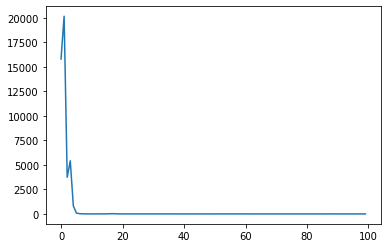

In [22]:
plt.plot(Losses)

In [23]:
Predicted = [predict(o,kernels1,kernels2) for o in org[:100]]

In [24]:
ThroughFrames(Predicted)

In [25]:
save_vid(Predicted,"Predicted/org_pred.mp4",24)

In [26]:
def save_kernels(kernels1, kernels2, file_path):
    torch.save({'kernels1': kernels1, 'kernels2': kernels2}, file_path)
    print(f'Kernels saved to {file_path}')
def load_kernels(file_path):
    checkpoint = torch.load(file_path)
    kernels1 = checkpoint['kernels1']
    kernels2 = checkpoint['kernels2']
    print(f'Kernels loaded from {file_path}')
    return kernels1, kernels2

In [27]:
save_kernels(kernels1, kernels2, 'trained_kernels.pth')
kernels1, kernels2 = load_kernels('trained_kernels.pth')

Kernels saved to trained_kernels.pth
Kernels loaded from trained_kernels.pth


In [28]:
cap0 = open_vid("VDB/U.mp4")
org0 = get_frames(cap0)

In [29]:
Predicted0 = [predict(o,kernels1,kernels2) for o in org0]

In [30]:
ThroughFrames(Predicted0)

In [31]:
save_vid(Predicted0,"Predicted/UU_pred.mp4",24)

In [ ]:
## Apply kernels over filtered image
## Border detector and Smoother
## Different kernel sizes
## Border detector small
## Smoother larger
## Check what happens if a kernel is omited
## Use past and future frames
## Formalize the problem
## What's the main objective of project?
## Other DNN strictures: GAN, Graphic Transformer